<a href="https://colab.research.google.com/github/Nikhil-Nandam/TensorFlow-Notebooks/blob/main/05_Transfer_Learning_in_TensorFlow_Part_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine- Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kond of transfer learning: Fine-Tuning.

In [1]:
# Check if we're using a GPU
!nvidia-smi

Wed Jun  1 11:08:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import your noteboooks (or elsewhere).

We've done this for some of the functions we've previously used here: [helper_functions.py](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py)

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-01 11:08:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-01 11:08:24 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`. So you'll have to redownload it of you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models models within in `tf.keras.applications` and apply them to our problem (recognizing images of food).

[tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-06-01 11:08:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   148MB/s    in 1.1s    

2022-06-01 11:08:28 (148 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = image_dataset_from_directory(directory=train_dir,
                                                     image_size=IMG_SIZE,
                                                     label_mode="categorical",
                                                     batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(directory=test_dir,
                                         image_size=IMG_SIZE,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.62857132e+01 1.32857151e+01 4.28571415e+00]
   [1.52142859e+01 1.22142859e+01 3.21428585e+00]
   [1.42857141e+01 1.12857141e+01 3.85714316e+00]
   ...
   [3.70663338e+01 2.80663319e+01 2.10663319e+01]
   [3.54489403e+01 2.64489403e+01 1.94489403e+01]
   [3.38163261e+01 2.48163280e+01 1.78163280e+01]]

  [[1.40714283e+01 1.40714283e+01 4.07142830e+00]
   [1.50000000e+01 1.50000000e+01 7.00000000e+00]
   [1.50000000e+01 1.50000000e+01 7.00000000e+00]
   ...
   [3.71734695e+01 2.81734695e+01 2.11734695e+01]
   [3.62244682e+01 2.72244701e+01 2.02244701e+01]
   [3.71479530e+01 2.81479511e+01 2.11479511e+01]]

  [[1.33571424e+01 1.47857141e+01 7.00000000e+00]
   [1.23265305e+01 1.37551022e+01 5.96938753e+00]
   [1.19285707e+01 1.33571424e+01 6.80612230e+00]
   ...
   [3.39285431e+01 2.49285450e+01 1.83571167e+01]
   [2.71274681e+01 1.81274681e+01 1.15560389e+01]
   [2.57806072e+01 1.67806072e+01 1.02091789e+01]]

  ...

  [[6.08673744e+01 4.32959023e+01 2.90816383e+01]
   [5

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

[Functional API](https://www.tensorflow.org/guide/keras/functional)

In [11]:
# Import required modules and functions
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Rescaling, GlobalAveragePooling2D, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [12]:
# 1. Create base model with tf.keras.applications
base_model = EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained oatterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you'll need to normalize inputs (you don't have to for EfficientNet)
# x = Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save it's history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220601-110837
Epoch 1/5
24/24 [==============================] - 23s 267ms/step - loss: 1.8851 - accuracy: 0.4067 - val_loss: 1.3713 - val_accuracy: 0.6678
Epoch 2/5
24/24 [==============================] - 4s 154ms/step - loss: 1.1227 - accuracy: 0.7493 - val_loss: 0.9610 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - 5s 185ms/step - loss: 0.8282 - accuracy: 0.8053 - val_loss: 0.8131 - val_accuracy: 0.8092
Epoch 4/5
24/24 [==============================] - 4s 154ms/step - loss: 0.6673 - accuracy: 0.8560 - val_loss: 0.6923 - val_accuracy: 0.8207
Epoch 5/5
24/24 [==============================] - 5s 185ms/step - loss: 0.5884 - accuracy: 0.8693 - val_loss: 0.6282 - val_accuracy: 0.8339


In [13]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.6076 - accuracy: 0.8504


[0.6076127886772156, 0.8503999710083008]

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


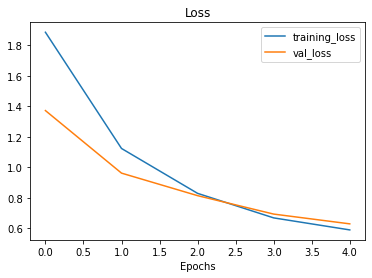

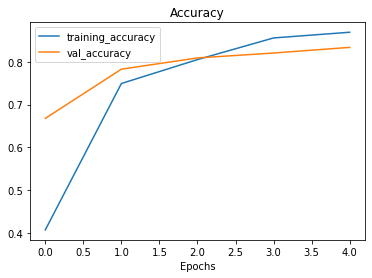

In [17]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through the `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [18]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

🛠 **Practice:** Try to do the same with the above 2 cells, this time use `GlobalMaxPool2D`... and see what happens.

In [20]:
from tensorflow.keras.layers import GlobalMaxPool2D

# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = GlobalMaxPool2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [21]:
# Let's replicate the GlobalMaxPool2D layer
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is, is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.GlobalAveragePool2D()` layer) which can then be used to extract patterns out of our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible result transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine tuning transfer learning with 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics. 

In [22]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-06-01 11:09:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   156MB/s    in 0.8s    

2022-06-01 11:09:32 (156 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
unzip_data("10_food_classes_1_percent.zip")

In [24]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [25]:
# How many image are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

### Getting and preprocessing data for model_1

In [26]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = image_dataset_from_directory(train_dir_1_percent,
                                                    label_mode="categorical",
                                                    image_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE) # default = 32

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE)                                                

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into our model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.RandomFlip()`
* `tf.keras.layers.RandomRotation()`
* `tf.keras.layers.RandomZoom()`
* `tf.keras.layers.RandomHeight()`
* `tf.keras.layers.RandomWidth()`
* `tf.keras.layers.Rescaling()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation
[TensorFlow Data Augmentation Document](https://www.tensorflow.org/tutorials/images/data_augmentation)

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster than on CPU)
* Image data augmentation only happens during training, so we can still export our model and use it elsewhere

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Rescaling

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2)
    # Rescaling(1./255) # keep for models like ResNet50V2 but EfficientNet models don't need rescaling
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

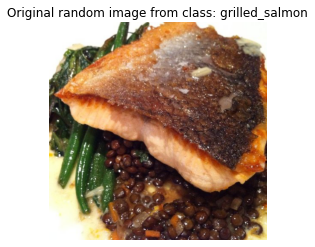

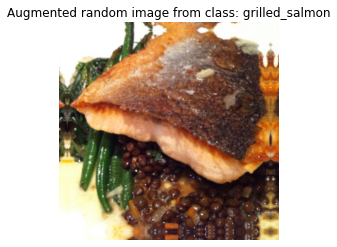

In [28]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)
plt.imshow(img);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)
augmented_img = augmented_img / 255.
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
plt.imshow(augmented_img);

## Model 1: Feature Extraction tansfer learning on 1% of the training data with data augmentation

In [29]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a denser layer on as the output
outputs = Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220601-110938
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4329 - accuracy: 0.0857 - val_loss: 2.2307 - val_accuracy: 0.1826
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.2146 - accuracy: 0.2571 - val_loss: 2.0958 - val_accuracy: 0.2681
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9988 - accuracy: 0.3714 - val_loss: 1.9755 - val_accuracy: 0.3684
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8111 - accuracy: 0.5000 - val_loss: 1.8856 - val_accuracy: 0.4145
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6396 - accuracy: 0.7143 - val_loss: 1.7907 - val_accuracy: 0.4737


In [30]:
# Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [31]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 1.8070 - accuracy: 0.4656


[1.806982398033142, 0.46560001373291016]

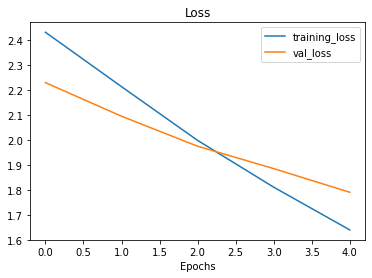

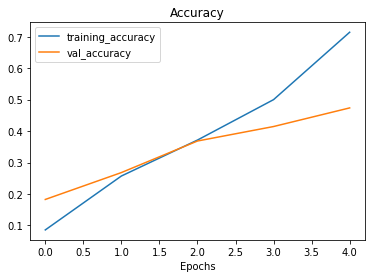

In [32]:
# How does the model with 1% of the training data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction transfer learning model with 10% of training data and data augmentation

In [33]:
# Get 10% of data... (uncomment if you don't have it)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [34]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [35]:
# Set data inputs
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = image_dataset_from_directory(train_dir_10_percent,
                                                     label_mode="categorical",
                                                     image_size=IMG_SIZE,
                                                     batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [36]:
# Create model_2 with data augmentation built in
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Rescaling

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2)
    # Rescaling(1./255) # keep for models like ResNet50V2 but EfficientNet models don't need rescaling
], name="data_augmentation")

In [37]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = Input(input_shape, name="input_layer")
# Augment our training images (augmentation doesn't occur on test data)
x = data_augmentation(inputs)
# Pass augmented images to base model but keep it in inference mode, this also ensures batchnorm layers don't get updated
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name="global_average_pooling_2D")(x)

# Output layer
outputs = Dense(10, activation="softmax", name="output_layer")(x)

model_2 = Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [38]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      save_best_only=False,
                                      save_freq="epoch",    # save for every epoch
                                      verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [40]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220601-112957
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0106 - accuracy: 0.3307
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 461ms/step - loss: 2.0106 - accuracy: 0.3307 - val_loss: 1.4872 - val_accuracy: 0.6711
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3420 - accuracy: 0.6920
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 435ms/step - loss: 1.3420 - accuracy: 0.6920 - val_loss: 1.0430 - val_accuracy: 0.7812
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0581 - accuracy: 0.7587
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 322ms/step - loss: 1.0581 - accuracy: 0.7587 - val_loss: 0.8398 - val_accuracy: 0.7977
Epoch

In [41]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.6076 - accuracy: 0.8504


[0.6076127290725708, 0.8503999710083008]

In [43]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.6955 - accuracy: 0.8048


[0.6955224871635437, 0.8047999739646912]

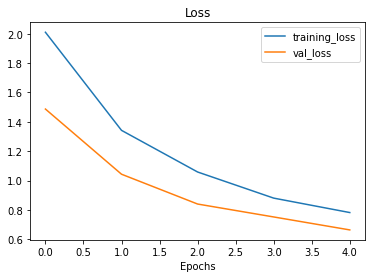

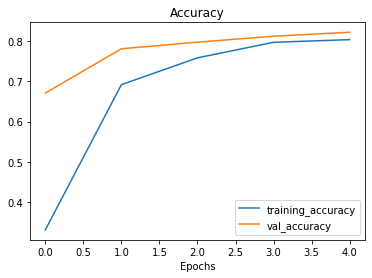

In [44]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [45]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [46]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.6955 - accuracy: 0.8048


In [47]:
# If the results fri=om our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [48]:
results_10_percent_data_aug

[0.6955224871635437, 0.8047999739646912]

In [49]:
loaded_weights_model_results

[0.6955223679542542, 0.8047999739646912]

In [50]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [51]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


## Model 3: Fine-tuning an existing model on 10% of data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [52]:
# Layers in loaded model
model_2.layers

In [53]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f104b2c0050> True
<keras.engine.sequential.Sequential object at 0x7f104b2b3890> True
<keras.engine.functional.Functional object at 0x7f104ae93650> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f104ae0df50> True
<keras.layers.core.dense.Dense object at 0x7f104adcaa50> True


In [54]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [55]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [59]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(learning_rate=0.0001),   # when fine tuning, we typically want to lower the learning rate by 10x
                metrics=["accuracy"])

> 🔑 **Note:** When using fine-tuning it is best practice to lower your learning rate by some amount. How much? This is a hyper paramter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).

A good resource for information on this is [ULMFiT Paper](https://arxiv.org/abs/1801.06146)

In [60]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [61]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [63]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],  # start training from the previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tuning_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tuning_last_10/20220601-133059
Epoch 5/10
24/24 [==============================] - 18s 385ms/step - loss: 0.6796 - accuracy: 0.8120 - val_loss: 0.5325 - val_accuracy: 0.8257
Epoch 6/10
24/24 [==============================] - 10s 393ms/step - loss: 0.5499 - accuracy: 0.8387 - val_loss: 0.5102 - val_accuracy: 0.8322
Epoch 7/10
24/24 [==============================] - 9s 364ms/step - loss: 0.4802 - accuracy: 0.8387 - val_loss: 0.4889 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 9s 369ms/step - loss: 0.4560 - accuracy: 0.8653 - val_loss: 0.4913 - val_accuracy: 0.8355
Epoch 9/10
24/24 [==============================] - 8s 318ms/step - loss: 0.4197 - accuracy: 0.8640 - val_loss: 0.4691 - val_accuracy: 0.8405
Epoch 10/10
24/24 [==============================] - 9s 365ms/step - loss: 0.3583 - accuracy: 0.8893 - val_loss: 0.5127 - val_accuracy: 0.8224


In [64]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for anothrt 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 8s 88ms/step - loss: 0.4921 - accuracy: 0.8280


In [65]:
results_10_percent_data_aug

[0.6955224871635437, 0.8047999739646912]

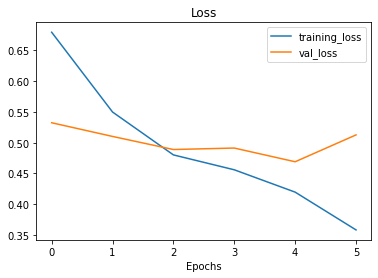

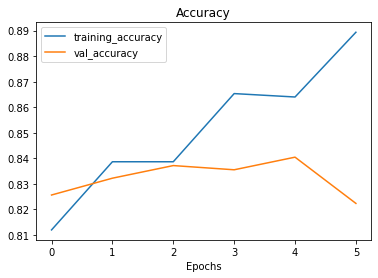

In [66]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [73]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects.
    """
    # Get the original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plot for accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Make plot for loss
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

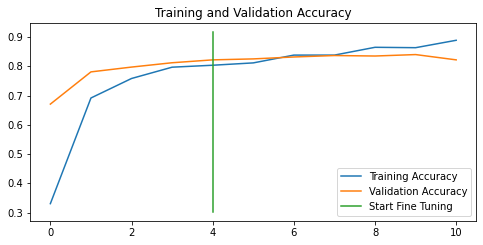

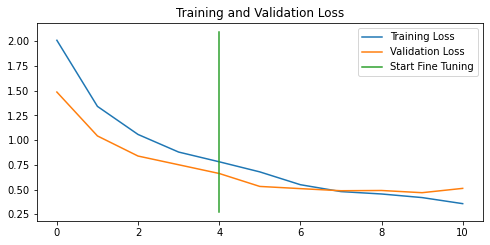

In [74]:
compare_histories(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data

In [75]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-06-01 13:51:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   224MB/s    in 2.2s    

2022-06-01 13:51:14 (224 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [76]:
# Setup training and test dirs
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [77]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 

In [78]:
# Setup data inputs
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_classes_full = image_dataset_from_directory(train_dir_all_data,
                                                          label_mode="categorical",
                                                          image_size=IMG_SIZE,
                                                          batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [79]:
# Evaluate model_2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 75ms/step - loss: 0.4921 - accuracy: 0.8280


[0.4921211004257202, 0.828000009059906]

In [80]:
results_fine_tune_10_percent

[0.4921211004257202, 0.828000009059906]

To train a fine-tuning model (model_4), we need to revert model_2 back to it's feature extraction weights.

In [81]:
# Load weights from checkpoint, that way, we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [82]:
# Let's evaluate model 2 now
model_2.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 0.6955 - accuracy: 0.8048


[0.6955224871635437, 0.8047999739646912]

In [83]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6955224871635437, 0.8047999739646912]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epocs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2, except this time, we're going to use all of the data (model_4).

In [84]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [86]:
# Let's drill into our base_model (EfficientNetB0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [90]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [91]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220601-143200
Epoch 5/10
235/235 [==============================] - 63s 237ms/step - loss: 0.7195 - accuracy: 0.7675 - val_loss: 0.4213 - val_accuracy: 0.8618
Epoch 6/10
235/235 [==============================] - 47s 200ms/step - loss: 0.5868 - accuracy: 0.8129 - val_loss: 0.4115 - val_accuracy: 0.8651
Epoch 7/10
235/235 [==============================] - 47s 198ms/step - loss: 0.5259 - accuracy: 0.8304 - val_loss: 0.3843 - val_accuracy: 0.8816
Epoch 8/10
235/235 [==============================] - 47s 199ms/step - loss: 0.4741 - accuracy: 0.8468 - val_loss: 0.3307 - val_accuracy: 0.8980
Epoch 9/10
235/235 [==============================] - 42s 177ms/step - loss: 0.4277 - accuracy: 0.8615 - val_loss: 0.3510 - val_accuracy: 0.8964
Epoch 10/10
235/235 [==============================] - 43s 180ms/step - loss: 0.4018 - accuracy: 0.8703 - val_loss: 0.3811 - val_accuracy: 0.8898


In [92]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 74ms/step - loss: 0.3352 - accuracy: 0.8916


[0.3351699411869049, 0.8916000127792358]

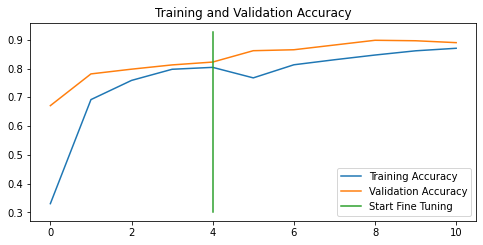

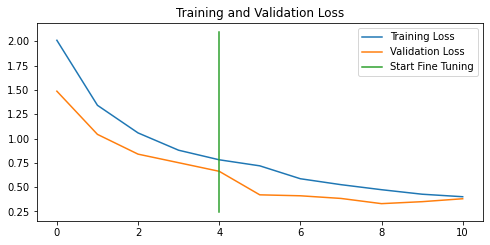

In [93]:
# How did fine-tuning go with more data?
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_classes_full,
                  initial_epochs=5)

## Viewing our experiment data on TensorBoard

> 🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
    --name "Transfer Learning Experiments with 10 Food101 Classes" \
    --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
    --one_shot # exits the uploader once it has finished uploading

My TensorBoard experiments are available at: [TensorBoard Experiments](https://tensorboard.dev/experiment/AsQARrk0RPOQVD8ExaI3Rw/)

In [96]:
!tensorboard dev list

https://tensorboard.dev/experiment/AsQARrk0RPOQVD8ExaI3Rw/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   AsQARrk0RPOQVD8ExaI3Rw
	Created              2022-06-01 14:51:04 (9 minutes ago)
	Updated              2022-06-01 14:51:09 (9 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4308370
https://tensorboard.dev/experiment/khQgLfa6RNOSKj2OXR2Lpg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   khQgLfa6RNOSKj2OXR2Lpg
	Created              2022-05-17 12:49:45
	Updated              2022-05-17 12:49:47
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes       

In [ ]:
# To delete an experiment
# !tensorboard dev delete --experiment-id AsQARrk0RPOQVD8ExaI3Rw